# Convergence study for a simple dual spring-mass system

In this notebook, we investigate the resolution of the simple dual mass-spring system via the use of our coupling techniques.

We will study the simulation of the dynamics of two mass-spring systems linked in series. A sketch of the system is given in Figure 1.

<!--- ![sketch](sketch_springmass.png "Figure 1 - Sketch of the system") -->
<img src="sketch_springmass.png" alt="sketch" width="500"/>
Both bodies have equal mass, and both springs have the same stiffness $k$.

The system dynamics are governed by the following equations :
\begin{equation}
    \begin{cases}
        m \ddot{x_1} &=  &k (x_2 - x_1) - k(x_1-0) \\
        m \ddot{x_2} &= -&k (x_2 - x_1) + k(1-x_2)
    \end{cases}
\end{equation}
which can be recast into the following first-order ODE system:
\begin{equation}
    \begin{pmatrix}
    \dot{x_1}\\
    \ddot{x_1} \\
    \dot{x_2}\\
    \ddot{x_2}
    \end{pmatrix}
    =
    \begin{pmatrix}
    0 & 1 & 0 & 0\\
    -\frac{2k}{m} & 0 & \frac{k}{m} & 0\\
    0 & 0 & 0 & 1\\
    \frac{k}{m} & 0 & -\frac{2k}{m} & 0\\
    \end{pmatrix}
    \begin{pmatrix}
    {x_1}\\
    \dot{x_1} \\
    {x_2}\\
    \dot{x_2}
    \end{pmatrix}
    +
    \begin{pmatrix}
    0\\
    0\\
    0\\
    \frac{k}{m}
    \end{pmatrix}
\end{equation}

## Coupled approach for the toy model
For the purpose of this notebook, we will consider that each of the masses constitutes one subsystem.
Such a subsystem can be sketched as follows:

<img src="sketch_single_mass.png" alt="sketch" width="400">

The $i$-th mass is subject to forces exerted via springs which link it to the previous and next masses in the spring-mass chain. In this subsystem, the inputs are therefore $u_i=(x_{i-1}, x_{i+1})^t$, the positions of the neighbour masses.

The dynamics of this subsystem can be written as:
$$m \ddot{x_i} = k (x_{i+1} - x_{i} - L_0) - k (x_i - x_{i-1} - L_0) $$

Introducing $X_i=(x_i, \dot{x}_i)^t$, we can recast this into the following first-order ODE system:
\begin{equation}
    \dot{X_i}
    =
    \begin{pmatrix}
    0 & 1\\
    -\frac{2k}{m} & 0
    \end{pmatrix}
    X_i
    +
    \begin{pmatrix}
    0 & \frac{k}{m}\\
    \frac{k}{m} & 0
    \end{pmatrix}
    u_i
\end{equation}
which matches the generic form $\dot{X_i} = f_(X_i,u_i,t)$ introduced previously.
Let us write the Python function that models this subsystem.

# Code
The following code cells are copied from the previous notebooks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import trapz as trapezoid
import scipy.interpolate
from rhapsopy.coupling import Orchestrator, BaseCoupler
from rhapsopy.accelerators import NewtonSolver, DampedNewtonSolver, IQNSolver, AitkenUnderrelaxationSolver, AitkenScalarSolver, FixedPointSolver, AndersonSolver, ExplicitSolver
from tqdm import tqdm # pour avoir une barre de progression
import time as pytime # pour pouvoir mesurer le temps de calcul
from rhapsopy.examples.mass_spring.model import SpringMassCoupler

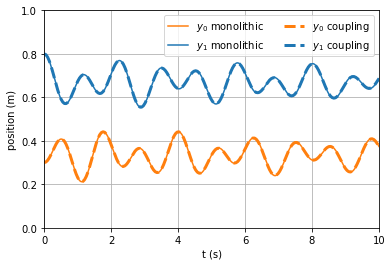

In [2]:
kspring=10.
mass=1.
L0=1.
d=0.1

coupler = SpringMassCoupler(kspring=kspring, mass=mass, L0=L0, d=d)
y0_global = np.array([0.3, 0, 0.8, 0])
tf = 10.

conductor = Orchestrator(coupler=coupler, order=3)
conductor.interfaceSolver = ExplicitSolver
conductor.gauss_seidel=True

# Compute coupled solution
nt = 200 # number of coupling time steps
solcoupled = conductor.basic_integration(y0=y0_global, t_vec=np.linspace(0,tf,nt))

# compute quasi-exact solution
sol = solve_ivp(fun=coupler.coupled_ode,
                y0=y0_global, t_span=[0.,10.],
                method='LSODA', atol=1e-6, rtol=1e-6)

# Graphical comparison
plt.figure()
plt.plot(sol.t, sol.y[0,:], color='tab:orange', label=r'$y_0$ monolithic')
plt.plot(sol.t, sol.y[2,:], color='tab:blue', label=r'$y_1$ monolithic')
plt.plot(solcoupled.t, solcoupled.y[0,:], color='tab:orange', linestyle='--', linewidth=3, label=r'$y_0$ coupling')
plt.plot(solcoupled.t, solcoupled.y[2,:], color='tab:blue', linestyle='--', linewidth=3, label=r'$y_1$ coupling')
plt.ylim(0,1)
plt.legend(ncol=2)
plt.grid(); plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('t (s)')
plt.ylabel('position (m)');

### Convergence study
We now wish to analyse the convergence of the coupled approach. To do so, we will perform a number of simulations with different prediction orders and time steps.
We simulate a short transient and compute the error with respect to a reference solution (quasi-exact solution computed with the monolithic approach).

One issue which will appear in our results is that, for the first coupling step, no previous coupling data points are available to build a high-order polynomial approximation of the coupling variables, hence the coupling variables can only be approximated as being constant (equal to their initial value) and the first coupling step is therefore first-order accurate only. For small enough time steps, the contirubtion of this first step to the global error becomes dominant, so that a high-order convergence cannot be reached. Indeed, the local truncation error of a step at with degree $p$ polynomials is $O(\Delta t^{p+2})$, which roughly contributes a $O(\Delta t^{p+1})$ to the global error. Thus if we want the global error error to behave like $O(\Delta t^n)$, the first step must be performed with polynomial apprxomiations of the coupling variables of degree at least $n-1$.

One way to make that possible is to cheat and perform a few steps with another method (say a monolithic adaptive solver) and use its solution points to initialise the polynomials. Another way is start with a very small time step, and increase it progressively. Both approaches are reminiscent of multistep methods and their starting mechanism.

In [25]:
bInitialisePredictors = True # If True, the high-order predictions are initialised with a previous solution
bExplicitCoupling = True # If False, WR iterations are performed to obtain an implicit coupling

In [30]:
order_vec= np.array(range(1,5+1)) # orders to be tested
nt_vec=1+np.unique( np.logspace( np.log10(10), np.log10(200), 6 ).astype(int) ) # number of steps to be tested

y0_global = np.array([0.3, 0, 0.8, 0])
tf_transient = 4. # length of the initial transient for the optional initialisation of the predictors
tf = 1.8 # Physical time simulated

# Compute a reference solution (**including** the initial transient in negative time)
solref = solve_ivp(fun=coupler.coupled_ode2,
                y0=y0_global, t_span=[-tf_transient,tf],
                method='DOP853', atol=1e-13, rtol=1e-13,
                dense_output=True)
y0_global[:] = solref.sol(0.) # the new initial state is that obtained after "tf_transient" seconds

# Perform coupled simulations
sols=[[] for k in order_vec]

for i, current_nt in enumerate(tqdm(nt_vec)): # loop over the number of time steps to be tested
    t_vec = np.linspace(0.,tf,current_nt)
    dt = t_vec[1] - t_vec[0]
    
    for j, current_order in enumerate(order_vec): # test each order
        coupler = SpringMassCoupler(kspring=kspring, mass=mass, L0=L0, d=d)
        conductor = Orchestrator(coupler=coupler, order=current_order)
        conductor.gauss_seidel=False

        
        if bInitialisePredictors:
          # initialize predictors with previous points from the quasi-exact reference solution
          reset_predictors = False
          for p in conductor.preds:
             p.reset()
          
          for jj in range(-max(order_vec)-1,1,1): # just to be sure we have added enough points
            # get interpolated solution
            current_t = jj*dt # negative !
            assert current_t > solref.t[0], 'better not extrapolate the reference solution outside its definition interval --> decrease dt or increase tf_transient'
            current_interp_y = solref.sol(current_t)
            # add this point to predictors' data
            conductor._advancePredictors(t=current_t,
                                         coupling_vars=conductor._getCouplingVars(t=current_t, y=current_interp_y) )
        else:
            reset_predictors = True
            
            
        if bExplicitCoupling: # explicit coupling
            conductor.interfaceSolver = ExplicitSolver
        else: # implicit coupling
            conductor.interfaceSolver = DampedNewtonSolver #AitkenUnderrelaxationSolver
            conductor.NITER_MAX = 1000
            conductor.waveform_tolerance = 1e-11
            
            
        t1 = pytime.time()
        sols[j].append( conductor.basic_integration(y0=y0_global.copy(), t_vec=t_vec,
                      reset_predictors=reset_predictors) )
        t2 = pytime.time()
        sols[j][-1].CPUtime = t2-t1 # restitution time
        assert sols[j][-1].success, 'simulation did not succeed' # check everything worked
        

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


Let us plot the solutions obtained for each prediction order tested:

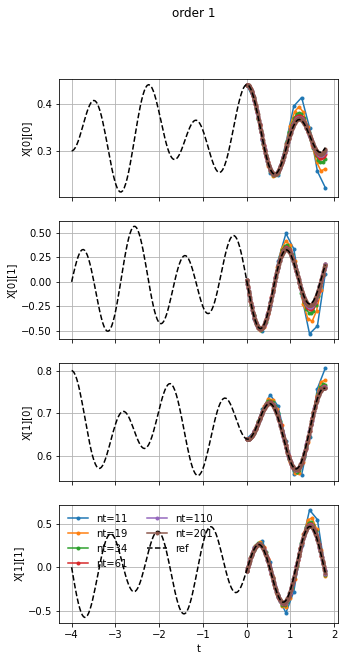

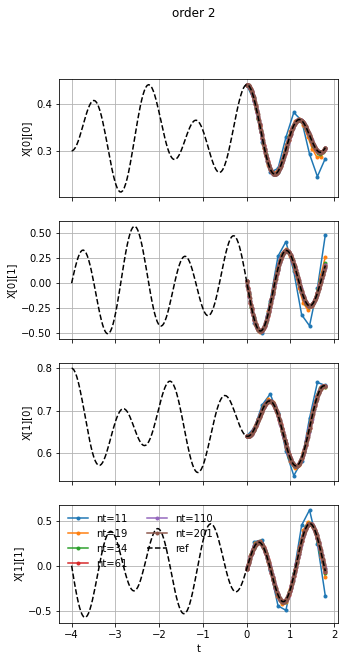

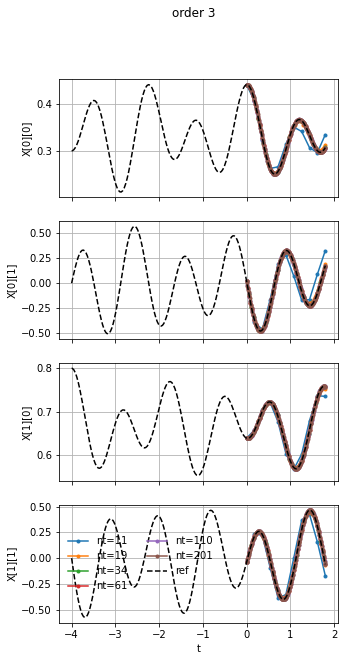

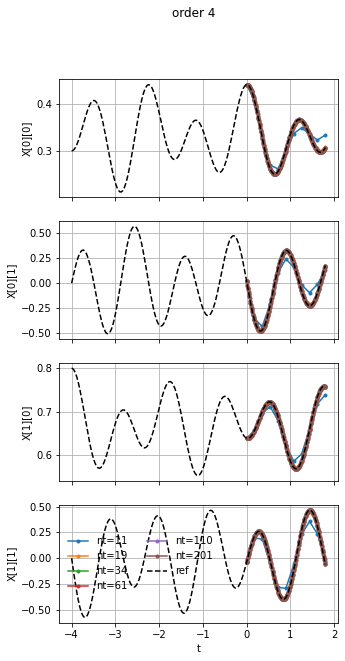

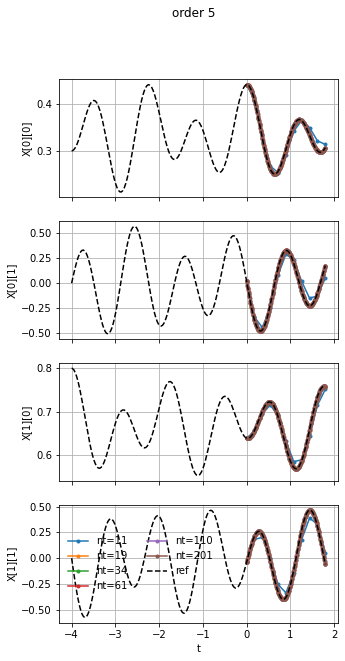

In [31]:
for j, current_order in enumerate(order_vec):
    fig,ax = plt.subplots(4,1,sharex=True,figsize=(5,10))
    for i, current_nt in enumerate(nt_vec):
        for ivar in range(4):
            n = sols[j][i].t.size
            assert n==current_nt
            ax[ivar].plot(sols[j][i].t, sols[j][i].y[ivar,:], label=f'nt={n}', marker='.')

    # plot reference solution
    for ivar in range(4):
        ax[ivar].plot(solref.t, solref.y[ivar,:], linestyle='--', label='ref', color=[0,0,0])
    ax[-1].legend(ncol=2, framealpha=0)
    ax[-1].set_xlabel('t')
    for a in ax:
        a.grid()
    ax[0].set_ylabel('X[0][0]')
    ax[1].set_ylabel('X[0][1]')
    ax[2].set_ylabel('X[1][0]')
    ax[3].set_ylabel('X[1][1]')
    fig.suptitle(f'order {current_order}')

To objectively analyse the accuracy achieved in the vairous simulations, we compute for each of them an error by comparing it to the reference solution. The error is computed as the integral over the whole time interval of the absolute difference between the each solution and the reference one.

In [32]:
err=np.zeros((order_vec.size, nt_vec.size))
for i, current_nt in enumerate(nt_vec):
    for k, current_order in enumerate(order_vec):
        current_sol = sols[k][i] # corresponding coupled simulation
        nt = current_sol.t.size
        
        # L1-norm of the error in time compared to the reference solution
        interpolated_reference_sol = solref.sol(current_sol.t) # interpolate reference onto the same time grid
        err_all_vars = trapezoid( abs(current_sol.y - interpolated_reference_sol),
                                      current_sol.t, axis=1)
        err[k,i]=(1/tf) * np.sum(err_all_vars, axis=0) / err_all_vars.shape[0]

Convergence graphs can now be obtained by plotting the evolution of this error with respect to $\Delta t$. Furthermore, convergence rates can be obtained by computing the slopes of these curves in a log-log scale.

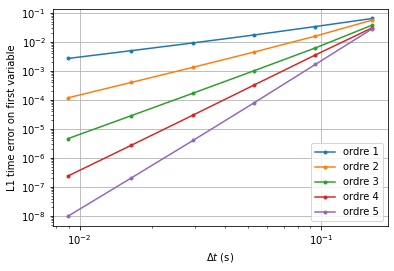

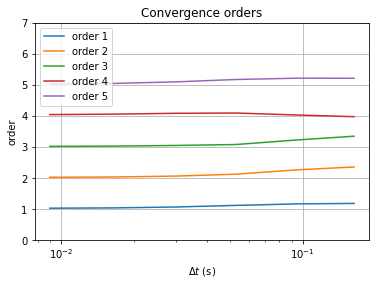

In [33]:
# Numerical estimation of convergence orders
plt.figure()
for k, current_order in enumerate(order_vec):
    plt.loglog(tf/nt_vec, err[k,:], label=f"ordre {current_order}", marker='.')
plt.grid()
plt.legend()
plt.xlabel(r"$\Delta t$ (s)")
plt.ylabel('error')
plt.ylabel('L1 time error on first variable')

plt.figure()
for k, current_order in enumerate(order_vec):
    plt.semilogx(tf/nt_vec, np.gradient(np.log10(err[k,:]), np.log10(tf/nt_vec)), label=f"order {current_order}")
plt.grid()
plt.ylim(0,max(order_vec+2))
plt.legend()
plt.xlabel(r"$\Delta t$ (s)")
plt.ylabel("order")
plt.title('Convergence orders');

We see that the orders of accuracy can be lower than expected if we start with a first-order accurate initial step...

To better compare the efficiency of each order, we now plot the achieved accuracy versus the associated computational cost (*work-precision diagram*):

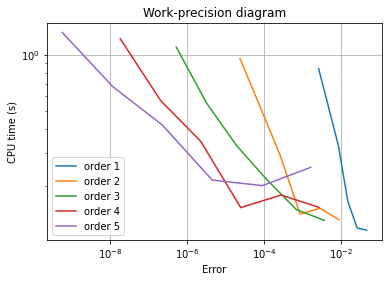

In [20]:
# Plot CPU time versus precision
plt.figure()
for k, current_order in enumerate(order_vec):
    plt.loglog(err[k,:],
               [s.CPUtime for s in sols[k]],
               label=f"order {current_order}")
plt.grid()
plt.legend()
plt.ylabel("CPU time (s)")
plt.xlabel("Error")
plt.title("Work-precision diagram");

We see that higher-order predictions lead to a lower error at a given computational cost, or equivalently a shorter restitution time for a given level of error.

Now, perform this study once more with explicit or implicit coupling, with or without pre-initialisation of the predictors:

   1) Without preinitialisation, the convergence orders do not exceed 2 ! The initial error due to first-order first coupling step completely dominates the global error...
    
   2) With implicit coupling, the error is lower than in explicit mode for the same number of steps, however the cost is increased... Or is it ?